In [1]:
import pandas as pd
from scipy import stats

from datasets import (load_AlphaFold_RoseTTAFold, 
                      load_I3D_exp_24, 
                      load_non_dubious_orfs, 
                      load_3did_DDIs)
from matplotlib import pyplot as plt

from plotting import validation_plot, COLOR_ALPHAFOLD_ROSETTAFOLD


In [2]:
afrf = load_AlphaFold_RoseTTAFold()
i3d = load_I3D_exp_24(remove_homodimers=True)

dmi = pd.read_csv('../data/external/elm_interactions_2024-01-30.tsv', sep='\t')
dmi = dmi.loc[(dmi['taxonomyElm'] == "559292(Saccharomyces cerevisiae S288c)")
              & (dmi['taxonomyDomain'] == "559292(Saccharomyces cerevisiae S288c)"), :]
id_map = pd.read_csv(
    "../data/external/sgd_uniprot_mapping.tsv", sep="\t", header=None
)
id_map[3] = id_map[3].fillna(id_map[1])
id_map = id_map.loc[:, [1, 3, 6]]
id_map.columns = ["orf_name", "gene_name", "uniprot_ac"]
valid_orfs = load_non_dubious_orfs()
id_map = id_map.loc[id_map['orf_name'].isin(valid_orfs), :]
uniprot_ac_to_orf_name = id_map.drop_duplicates("uniprot_ac").set_index("uniprot_ac")["orf_name"]
dmi['orf_name_ELM'] = dmi['interactorElm'].map(uniprot_ac_to_orf_name)
dmi['orf_name_domain'] = dmi['interactorDomain'].map(uniprot_ac_to_orf_name)
dmi['orf_name_a'] = dmi[['orf_name_ELM', 'orf_name_domain']].min(axis=1)
dmi['orf_name_b'] = dmi[['orf_name_ELM', 'orf_name_domain']].max(axis=1)
dmi['pair'] = dmi['orf_name_a'] + '_' + dmi['orf_name_b']
if (dmi['orf_name_a'] == dmi['orf_name_b']).any():
    raise UserWarning('unexpected homodimers')

ddi = load_3did_DDIs()
i3d['pdb_chains_ids'] = i3d['PDB_ID'] + '_' + i3d[['CHAIN1', 'CHAIN2']].min(axis=1) + '_' + i3d[['CHAIN1', 'CHAIN2']].max(axis=1)
ddi['pdb_chains_ids'] = ddi['pdb_id'] + '_' + ddi[['chain_1', 'chain_2']].min(axis=1) + '_' + ddi[['chain_1', 'chain_2']].max(axis=1)

ddi = pd.merge(i3d.reset_index(), ddi, how='inner', on='pdb_chains_ids')
# remove small number that map to both DDI and DMI
ddi = ddi.loc[~ddi['pair'].isin(dmi['pair']), :]
# join to get PDB info
dmi = dmi.loc[dmi['pair'].isin(i3d.index), :]
ddi = ddi.drop_duplicates('pair')
dmi = dmi.drop_duplicates('pair')

SignificanceResult(statistic=6.022751895991332, pvalue=0.03241138902269339)


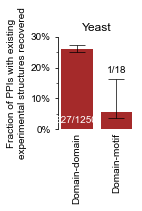

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.4, h=1.7)
pos = [ddi['pair'].isin(afrf.index).sum(),
      dmi['pair'].isin(afrf.index).sum()]
ns = [ddi.shape[0], dmi.shape[0]]
print(stats.fisher_exact([pos, [ns[0] - pos[0], ns[1] - pos[1]]], alternative='greater'))
validation_plot(positives=pos,
                n_tested=ns,
                labels=['Domain-domain', 'Domain-motif'],
                colors=[COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_ALPHAFOLD_ROSETTAFOLD],
                y_max=0.3,
                ax=ax,
                  errorbar_capsize=0.5,
                errorbar_thickness=0.7,
                         )
ax.set_ylabel('Fraction of PPIs with existing\nexperimental structures recovered')
ax.set_title('Yeast')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('white')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
fig.savefig('../figures/AFRF_recovery-of-PDB_split-by-DDI-vs-DMI_bar.pdf', bbox_inches='tight')

In [4]:
dmi = pd.read_csv('../data/external/elm_interactions_2024-01-30.tsv', sep='\t')
dmi = dmi.loc[(dmi['taxonomyElm'] == "559292(Saccharomyces cerevisiae S288c)")
              & (dmi['taxonomyDomain'] == "559292(Saccharomyces cerevisiae S288c)"), :]
id_map = pd.read_csv(
    "../data/external/sgd_uniprot_mapping.tsv", sep="\t", header=None
)
id_map[3] = id_map[3].fillna(id_map[1])
id_map = id_map.loc[:, [1, 3, 6]]
id_map.columns = ["orf_name", "gene_name", "uniprot_ac"]
valid_orfs = load_non_dubious_orfs()
id_map = id_map.loc[id_map['orf_name'].isin(valid_orfs), :]
uniprot_ac_to_orf_name = id_map.drop_duplicates("uniprot_ac").set_index("uniprot_ac")["orf_name"]
dmi['orf_name_ELM'] = dmi['interactorElm'].map(uniprot_ac_to_orf_name)
dmi['orf_name_domain'] = dmi['interactorDomain'].map(uniprot_ac_to_orf_name)
dmi['orf_name_a'] = dmi[['orf_name_ELM', 'orf_name_domain']].min(axis=1)
dmi['orf_name_b'] = dmi[['orf_name_ELM', 'orf_name_domain']].max(axis=1)
dmi['pair'] = dmi['orf_name_a'] + '_' + dmi['orf_name_b']
if (dmi['orf_name_a'] == dmi['orf_name_b']).any():
    raise UserWarning('unexpected homodimers')

prs = pd.read_csv('../supplementary_tables/scPRS-v2.tsv', sep='\t')
prs['pair'] = prs['orf_name_a'] + '_' + prs['orf_name_b']


print(prs['pair'].isin(ddi['pair']).sum())
print(prs['pair'].isin(dmi['pair']).sum())

  

31
1


In [5]:
ddi['pair'].nunique()

1250

In [6]:
dmi['pair'].nunique()

95